In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mcdonalds/mcdonalds.csv


In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.utils import resample
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import jaccard_score

In [3]:
#loading the dataset

df = pd.read_csv('/kaggle/input/mcdonalds/mcdonalds.csv')
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [4]:
#encoding the categorical variables

df[df.columns[:11]] = OrdinalEncoder().fit_transform(df[df.columns[:11]])
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-3,61,Every three months,Female
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,+2,51,Every three months,Female
2,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,+1,62,Every three months,Female
3,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,+4,69,Once a week,Female
4,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,+2,49,Once a month,Male


In [5]:
#mean value of each attribute

df.mean(numeric_only = True)

yummy          0.552650
convenient     0.907777
spicy          0.093599
fattening      0.867171
greasy         0.526497
fast           0.900206
cheap          0.598761
tasty          0.644184
expensive      0.357880
healthy        0.198899
disgusting     0.242946
Age           44.604955
dtype: float64

In [6]:
#explained variance of each principal component

X = df[df.columns[:11]]

pca = PCA()
pca.fit(X)

pd.DataFrame({'Standard Deviation':np.sqrt(pca.explained_variance_),
                    'Proportion of Variance':np.array(pca.explained_variance_ratio_),
                    'Cumulative Proportion':np.array(np.cumsum(pca.explained_variance_ratio_))
                   },
                  index = ['PC1',"PC2",'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11'])

,Standard Deviation,Proportion of Variance,Cumulative Proportion
PC1,0.757050,0.299447,0.299447
PC2,0.607456,0.192797,0.492244
PC3,0.504619,0.133045,0.625290
PC4,0.398799,0.083096,0.708386
PC5,0.337405,0.059481,0.767866
PC6,0.310275,0.050300,0.818166
PC7,0.289697,0.043849,0.862015
PC8,0.275122,0.039548,0.901563
PC9,0.265251,0.036761,0.938323
PC10,0.248842,0.032353,0.970677


In [7]:
#factor loadings of all features

pd.DataFrame(pca.components_.T,index = df.columns[:11], 
                   columns = ['PC1',"PC2",'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11'])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
yummy,-0.476933,0.363790,-0.304444,0.055162,-0.307535,0.170738,-0.280519,0.013041,0.572403,-0.110284,0.045439
convenient,-0.155332,0.016414,-0.062515,-0.142425,0.277608,-0.347830,-0.059738,-0.113079,-0.018465,-0.665818,-0.541616
spicy,-0.006356,0.018809,-0.037019,0.197619,0.070620,-0.355087,0.707637,0.375934,0.400280,-0.075634,0.141730
fattening,0.116232,-0.034094,-0.322359,-0.354139,-0.073405,-0.406515,-0.385943,0.589622,-0.160512,-0.005338,0.250910
greasy,0.304443,-0.063839,-0.802373,0.253960,0.361399,0.209347,0.036170,-0.138241,-0.002847,0.008707,0.001642
fast,-0.108493,-0.086972,-0.064642,-0.097363,0.107930,-0.594632,-0.086846,-0.627799,0.166197,0.239532,0.339265
cheap,-0.337186,-0.610633,-0.149310,0.118958,-0.128973,-0.103241,-0.040449,0.140060,0.076069,0.428087,-0.489283
tasty,-0.471514,0.307318,-0.287265,-0.002547,-0.210899,-0.076914,0.360453,-0.072792,-0.639086,0.079184,0.019552
expensive,0.329042,0.601286,0.024397,0.067816,-0.003125,-0.261342,-0.068385,0.029539,0.066996,0.454399,-0.490069
healthy,-0.213711,0.076593,0.192051,0.763488,0.287846,-0.178226,-0.349616,0.176303,-0.185572,-0.038117,0.157608


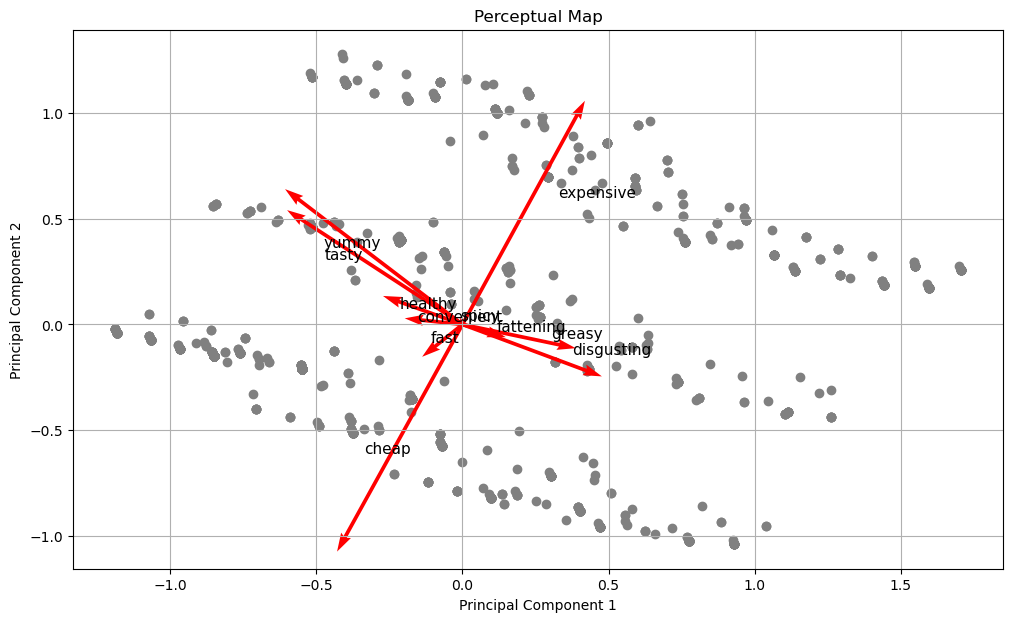

In [8]:
#perceptual map

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)  

cols=df.columns[:11]

plt.figure(figsize=(12,7))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c='grey')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Perceptual Map')
plt.grid(True)

origin = [0, 0] 
i=0
for component in pca.components_.T:
    plt.quiver(*origin, component[0], component[1], color='red', scale=2.5, width=0.004)
    plt.text(component[0], component[1], cols[i], color='black', fontsize=11)
    i+=1
plt.show()

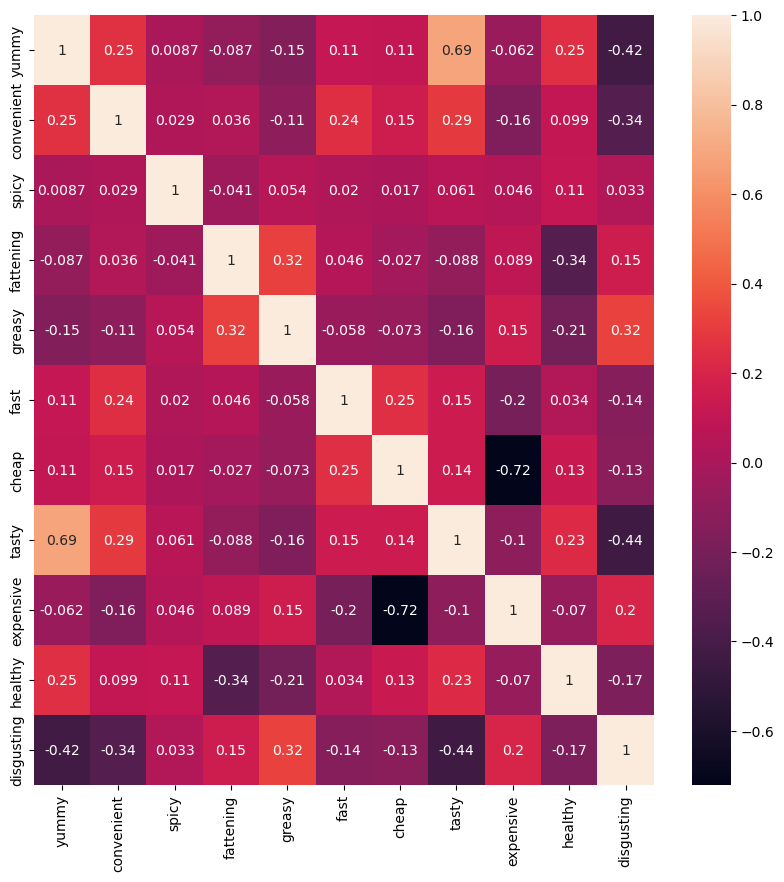

In [9]:
#heatmap for correlation

plt.figure(figsize=(10,10))
sns.heatmap(X.corr(),annot=True);

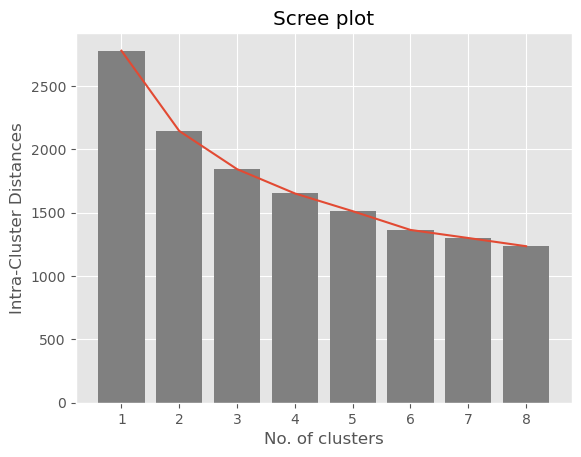

In [10]:
#using k-means to cluster the data and plotting the scree plot

intra_distance = []
clusters=[i for i in range(1,9)]
for cluster in clusters:
    kmeans = KMeans(n_clusters = cluster, n_init = 'auto', init='random',max_iter=10, random_state=42)
    kmeans.fit(X)
    intra_distance.append(kmeans.inertia_)
    
plt.style.use('ggplot')
plt.bar(x=clusters,height=intra_distance,color='grey')
plt.xlabel('No. of clusters')
plt.ylabel('Intra-Cluster Distances')
plt.title('Scree plot')
plt.plot(clusters,intra_distance);

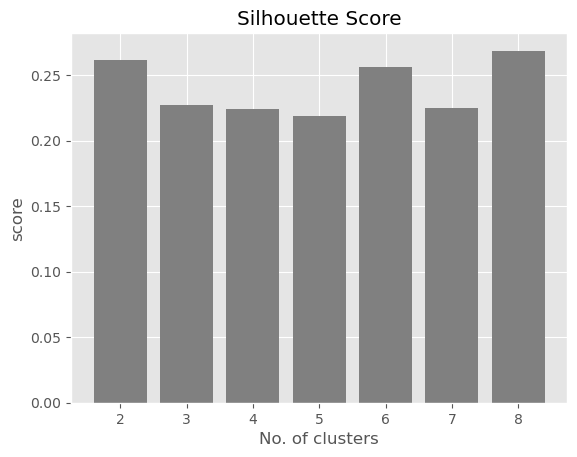

In [11]:
sil_scores=[]

clusters=[i for i in range(2,9)]
for cluster in clusters:
    kmeans=KMeans(n_clusters=cluster, n_init='auto', init='random',max_iter=10, random_state=42)
    kmeans.fit(X)
    tr=kmeans.labels_
    sil_scores.append(silhouette_score(X,tr,sample_size=100))

plt.bar(x=clusters,height=sil_scores,color='grey')
plt.xlabel('No. of clusters')
plt.ylabel('score')
plt.title('Silhouette Score');

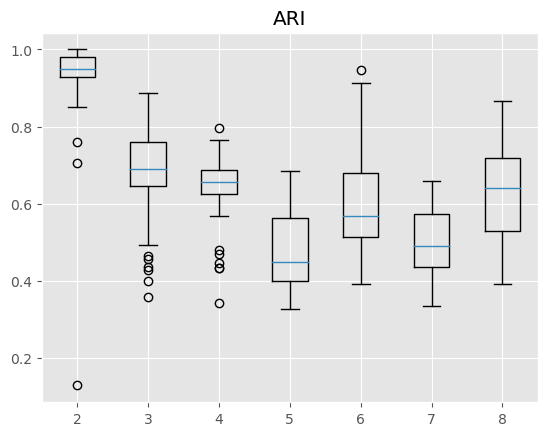

In [12]:
#Adjusted rand score for all clusters using True labels

rand_scores=[]

for cluster in clusters:
    scores=[]
    kmeans = KMeans(n_clusters = cluster, n_init = 'auto', init='random',max_iter=10, random_state=42)
    kmeans.fit(X)
    true_labels = kmeans.labels_
    
    X_new=X.copy()
    X_new['true']=true_labels

    for i in range(50):
        bootstrap_data = resample(X_new,replace=True,n_samples=600)
        
        kmeans_bs = KMeans(n_clusters=cluster,n_init='auto', init='random',max_iter=10)
        kmeans_bs.fit(bootstrap_data.drop('true',axis=1))
        pred_labels = kmeans_bs.labels_
        
        scores.append(adjusted_rand_score(pred_labels,bootstrap_data['true']))
    
    rand_scores.append(scores)

plt.boxplot(rand_scores)
plt.xticks(range(1,8),clusters)
plt.title('ARI');

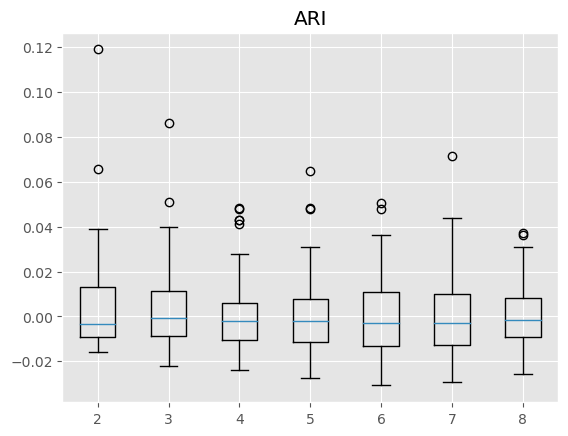

In [13]:
#Adjusted rand score for all clusters using 2 sets of bootstrapped values

rand_scores=[]

for cluster in clusters:
    scores=[]
    
    for i in range(100):
        data1 = resample(X,replace=True,n_samples=100)
        data2 = resample(X,replace=True,n_samples=100)
        
        k1 = KMeans(n_clusters=cluster,n_init='auto', init='random',max_iter=10)
        k1.fit(data1)
        
        k2= KMeans(n_clusters=cluster,n_init='auto', init='random',max_iter=10)
        k2.fit(data2)
        
        scores.append(adjusted_rand_score(k1.labels_,k2.labels_))
    
    rand_scores.append(scores)

plt.boxplot(rand_scores)
plt.xticks(range(1,8),clusters)
plt.title('ARI');

In [14]:
# calculating similarities using distances of each consumer to all segment respresentatives.

kmeans = KMeans(n_clusters = 4, n_init = 'auto', init='random',max_iter=10, random_state=42)
kmeans.fit(X)

sims = []
for point in np.array(X):
    distances = [math.dist(point, center) for center in kmeans.cluster_centers_]
    total_sum = np.sum(np.exp(-np.array(distances)))
    similarities = [np.exp(-d) / total_sum for d in distances]
    sims.append(similarities)
    
sims=np.array(sims)
np.sum(sims,axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

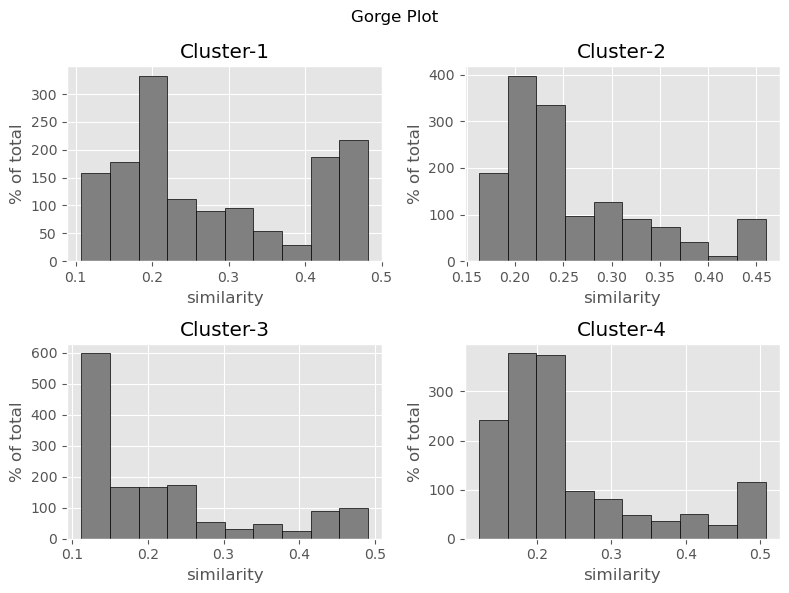

In [15]:
#gorge plot using similarities

c1, c2, c3, c4 = sims[:, 0], sims[:, 1], sims[:, 2], sims[:, 3]

plt.figure(figsize=(8, 6))
plt.suptitle('Gorge Plot')


plt.subplot(2, 2, 1)
plt.hist(c1, bins=10,color='grey',edgecolor='black')
plt.xlabel('similarity')
plt.ylabel('% of total')
plt.title('Cluster-1')

plt.subplot(2, 2, 2)
plt.hist(c2, bins=10,color='grey',edgecolor='black')
plt.xlabel('similarity')
plt.ylabel('% of total')
plt.title('Cluster-2')

plt.subplot(2, 2, 3)
plt.hist(c3, bins=10,color='grey',edgecolor='black')
plt.xlabel('similarity')
plt.ylabel('% of total')
plt.title('Cluster-3')

plt.subplot(2, 2, 4)
plt.hist(c4, bins=10,color='grey',edgecolor='black')
plt.xlabel('similarity')
plt.ylabel('% of total')
plt.title('Cluster-4')

plt.tight_layout()

plt.show()

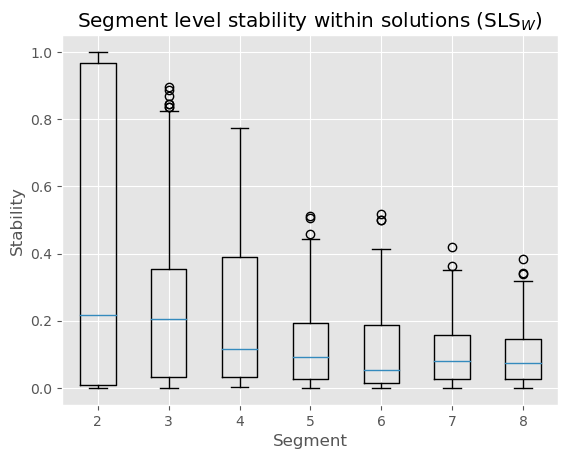

In [16]:
#Segment level stability within solutions using jaccard score 

jaccard_scores=[]

for cluster in clusters:
    scores=[]
    kmeans = KMeans(n_clusters = cluster, n_init = 'auto', init='random',max_iter=10, random_state=42)
    kmeans.fit(X)
    true_labels = kmeans.labels_
    
    X_new=X.copy()
    X_new['true']=true_labels

    for i in range(100):
        bootstrap_data = resample(X_new,replace=True,n_samples=300)
        
        kmeans_bs = KMeans(n_clusters=cluster,n_init='auto', init='random',max_iter=10)
        kmeans_bs.fit(bootstrap_data.drop('true',axis=1))
        pred_labels = kmeans_bs.labels_
        
        scores.append(jaccard_score(pred_labels,bootstrap_data['true'],average='weighted'))
    
    jaccard_scores.append(scores)

plt.boxplot(jaccard_scores)
plt.xticks(range(1,8),clusters)
plt.xlabel('Segment')
plt.ylabel('Stability')
plt.title('Segment level stability within solutions (SLS$_W$)');

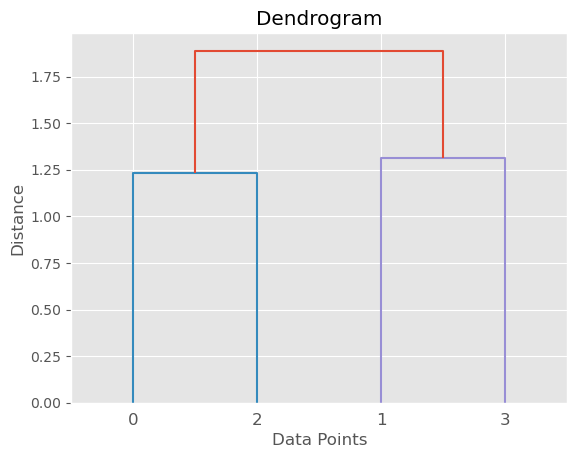

In [17]:
#dendrogram for 4 segment clustering

kmeans = KMeans(n_clusters=4, n_init='auto', random_state=21, init='random', max_iter=10)
clusters = kmeans.fit_predict(X)

cluster_centers = kmeans.cluster_centers_

dist_matrix = pdist(cluster_centers)

linkage_matrix = linkage(dist_matrix, method='ward')

dendrogram(linkage_matrix)

plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram')

plt.show()

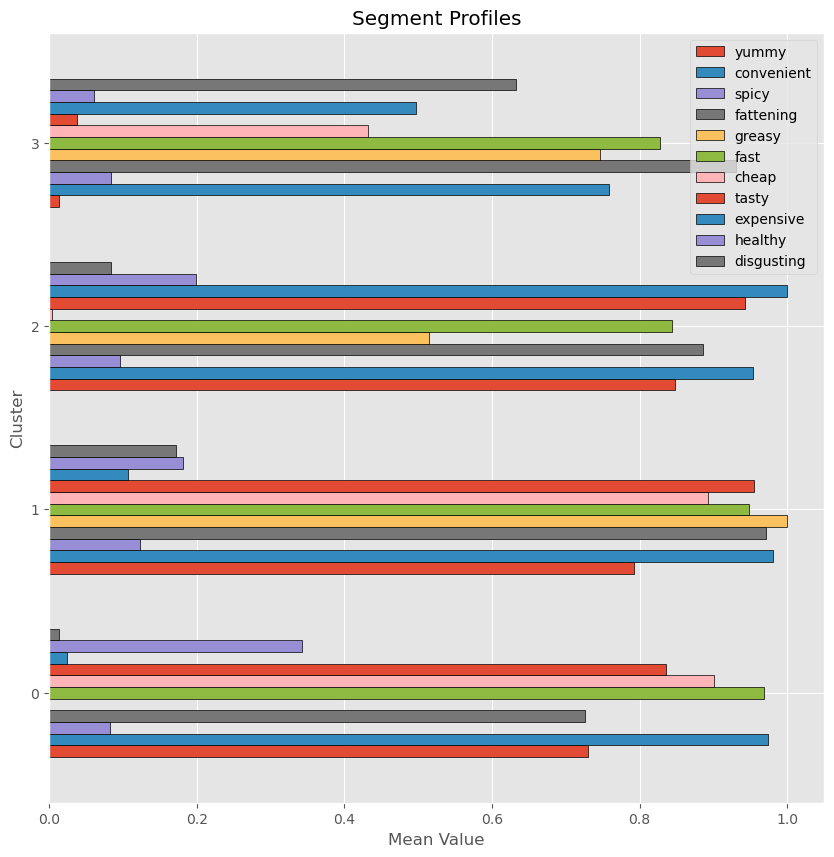

In [18]:
#segment profiling

kmeans = KMeans(n_clusters=4, n_init='auto', random_state=32, init='random', max_iter = 10)
kmeans.fit(X)

X_lab=X.copy()
X_lab['clusters']=kmeans.labels_

seg_profile = X_lab.groupby('clusters').mean()

seg_profile.plot(kind='barh' , width=0.7, figsize=(10,10), edgecolor='black')
plt.ylabel('Cluster')
plt.xlabel('Mean Value')
plt.title('Segment Profiles')
plt.legend(loc='best')

plt.show()

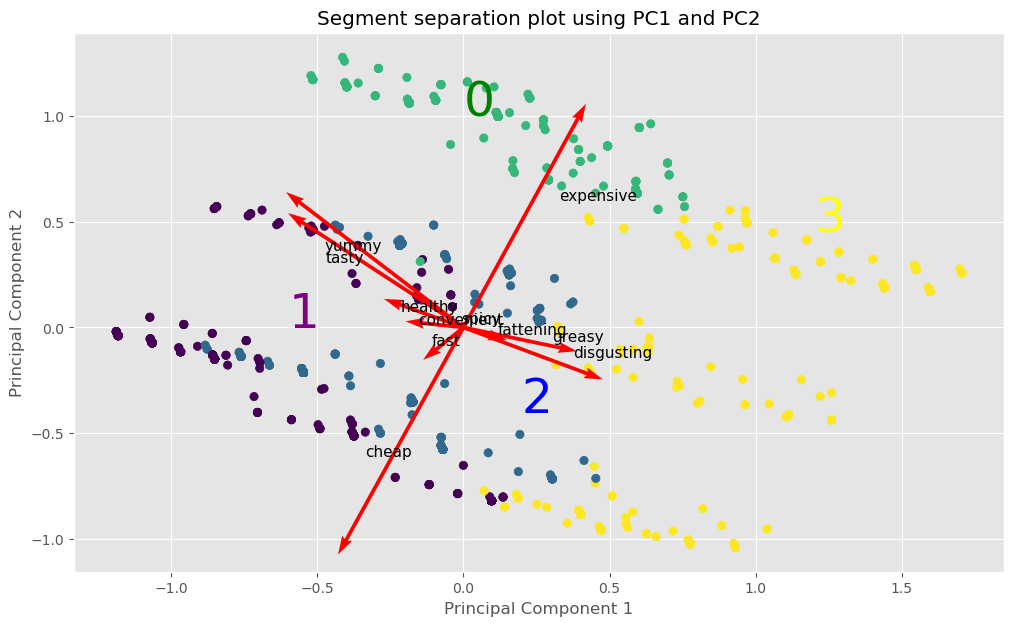

In [19]:
#perceptual map using segment profiling

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)  

cols=df.columns[:11]

plt.figure(figsize=(12,7))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=X_lab['clusters'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Segment separation plot using PC1 and PC2')  
plt.text(0,1,'0',fontsize=35, color = 'green')
plt.text(1.2,0.45,'3',fontsize=35, color = 'yellow')
plt.text(0.2,-0.4,'2',fontsize=35, color = 'blue')
plt.text(-0.6,0,'1',fontsize=35, color = 'purple')
plt.grid(True)

origin = [0, 0] 
i=0
for component in pca.components_.T:
    plt.quiver(*origin, component[0], component[1], color='red', scale=2.5, width=0.004)
    plt.text(component[0], component[1], cols[i], color='black', fontsize=11)
    i+=1

plt.show()

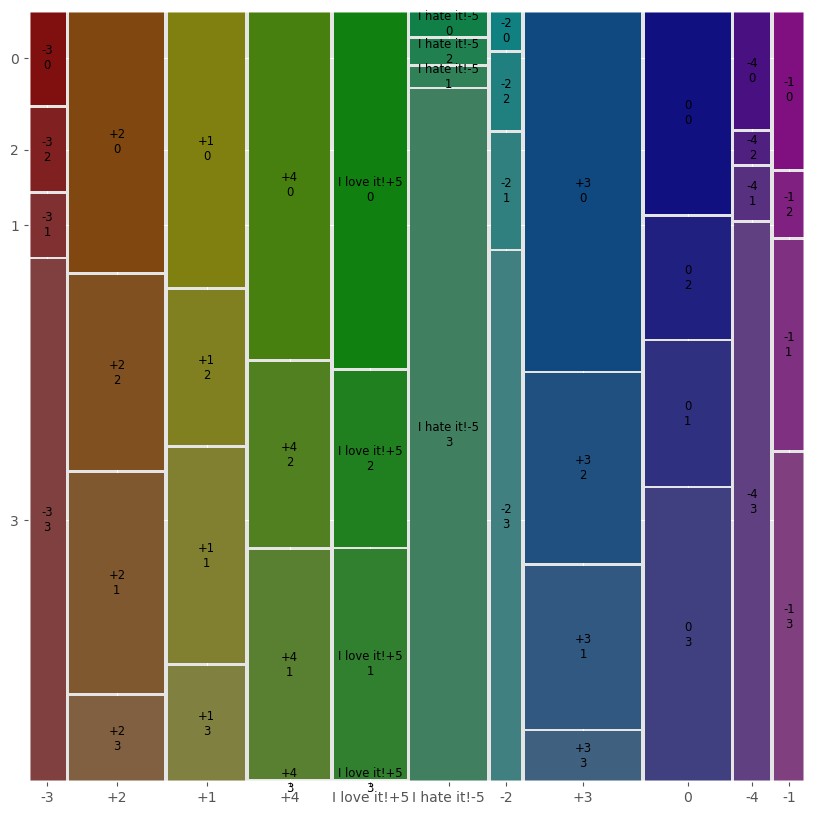

In [20]:
#mosaic plot for Likes

df_lab=df.copy()
df_lab['cluster'] = kmeans.labels_

plt.rcParams['figure.figsize']=(10,10)
mosaic(df_lab,['Like','cluster']);

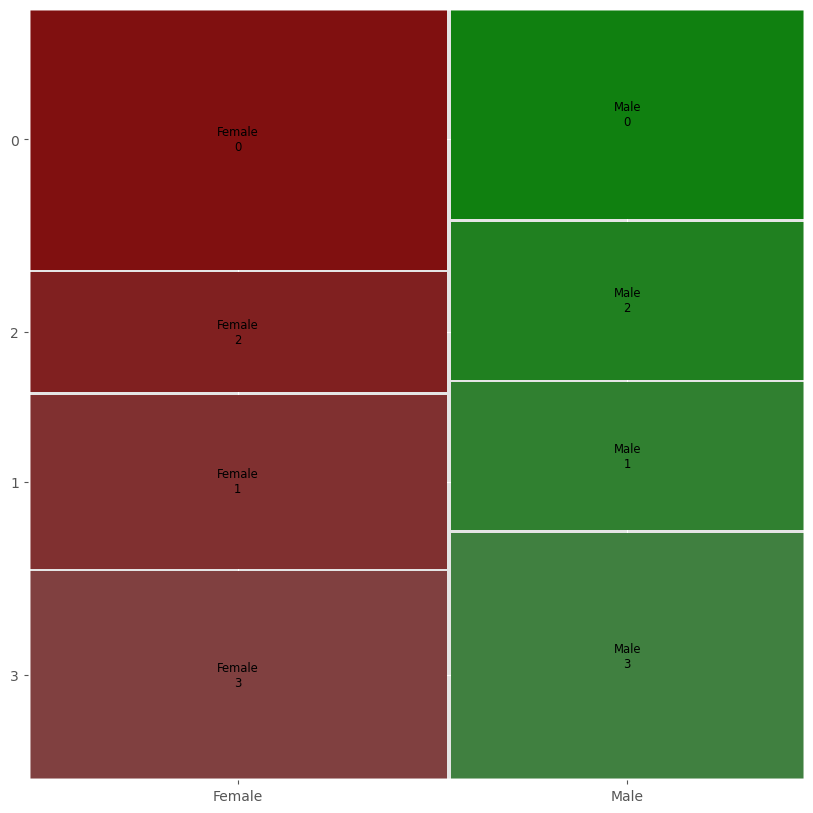

In [21]:
#mosaic plot for gender

plt.rcParams['figure.figsize']=(10,10)
mosaic(df_lab,['Gender','cluster']);

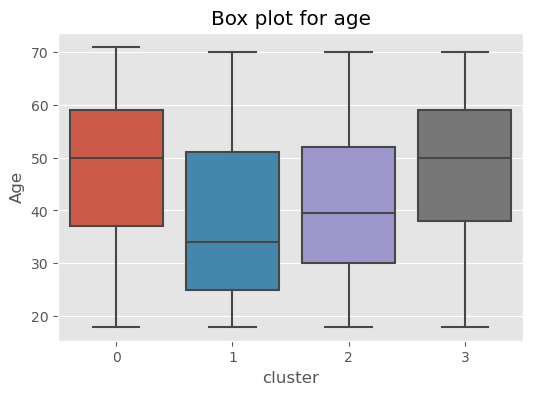

In [22]:
#box plot for age for different segments

plt.figure(figsize=(6,4))
sns.boxplot(x='cluster', y='Age', data=df_lab)
plt.title('Box plot for age');

In [23]:
#fitting a decision tree classifier on the data

df_lab['Like'] = df_lab['Like'].replace({'I hate it!-5':0 ,'-4':1, '-3':2, '-2':3, '-1':4, '0':5, '+1':6, '+2':7, '+3':8, '+4':9, 'I love it!+5':10})
df_lab['VisitFrequency'] = df_lab['VisitFrequency'].replace({'Never':0, 'Once a week':1, 'More than once a week':2, 'Once a month':3, 'Every three months':4, 'Once a year':5})
df_lab['cluster'] = df_lab['cluster'].replace({3:1,1:0,2:0})

X = df_lab[['Like', 'Age', 'VisitFrequency']]
y = df_lab['cluster']

dtc = DecisionTreeClassifier(random_state=12, max_depth = 3)
dtc.fit(X,y)

DecisionTreeClassifier(max_depth=3, random_state=12)

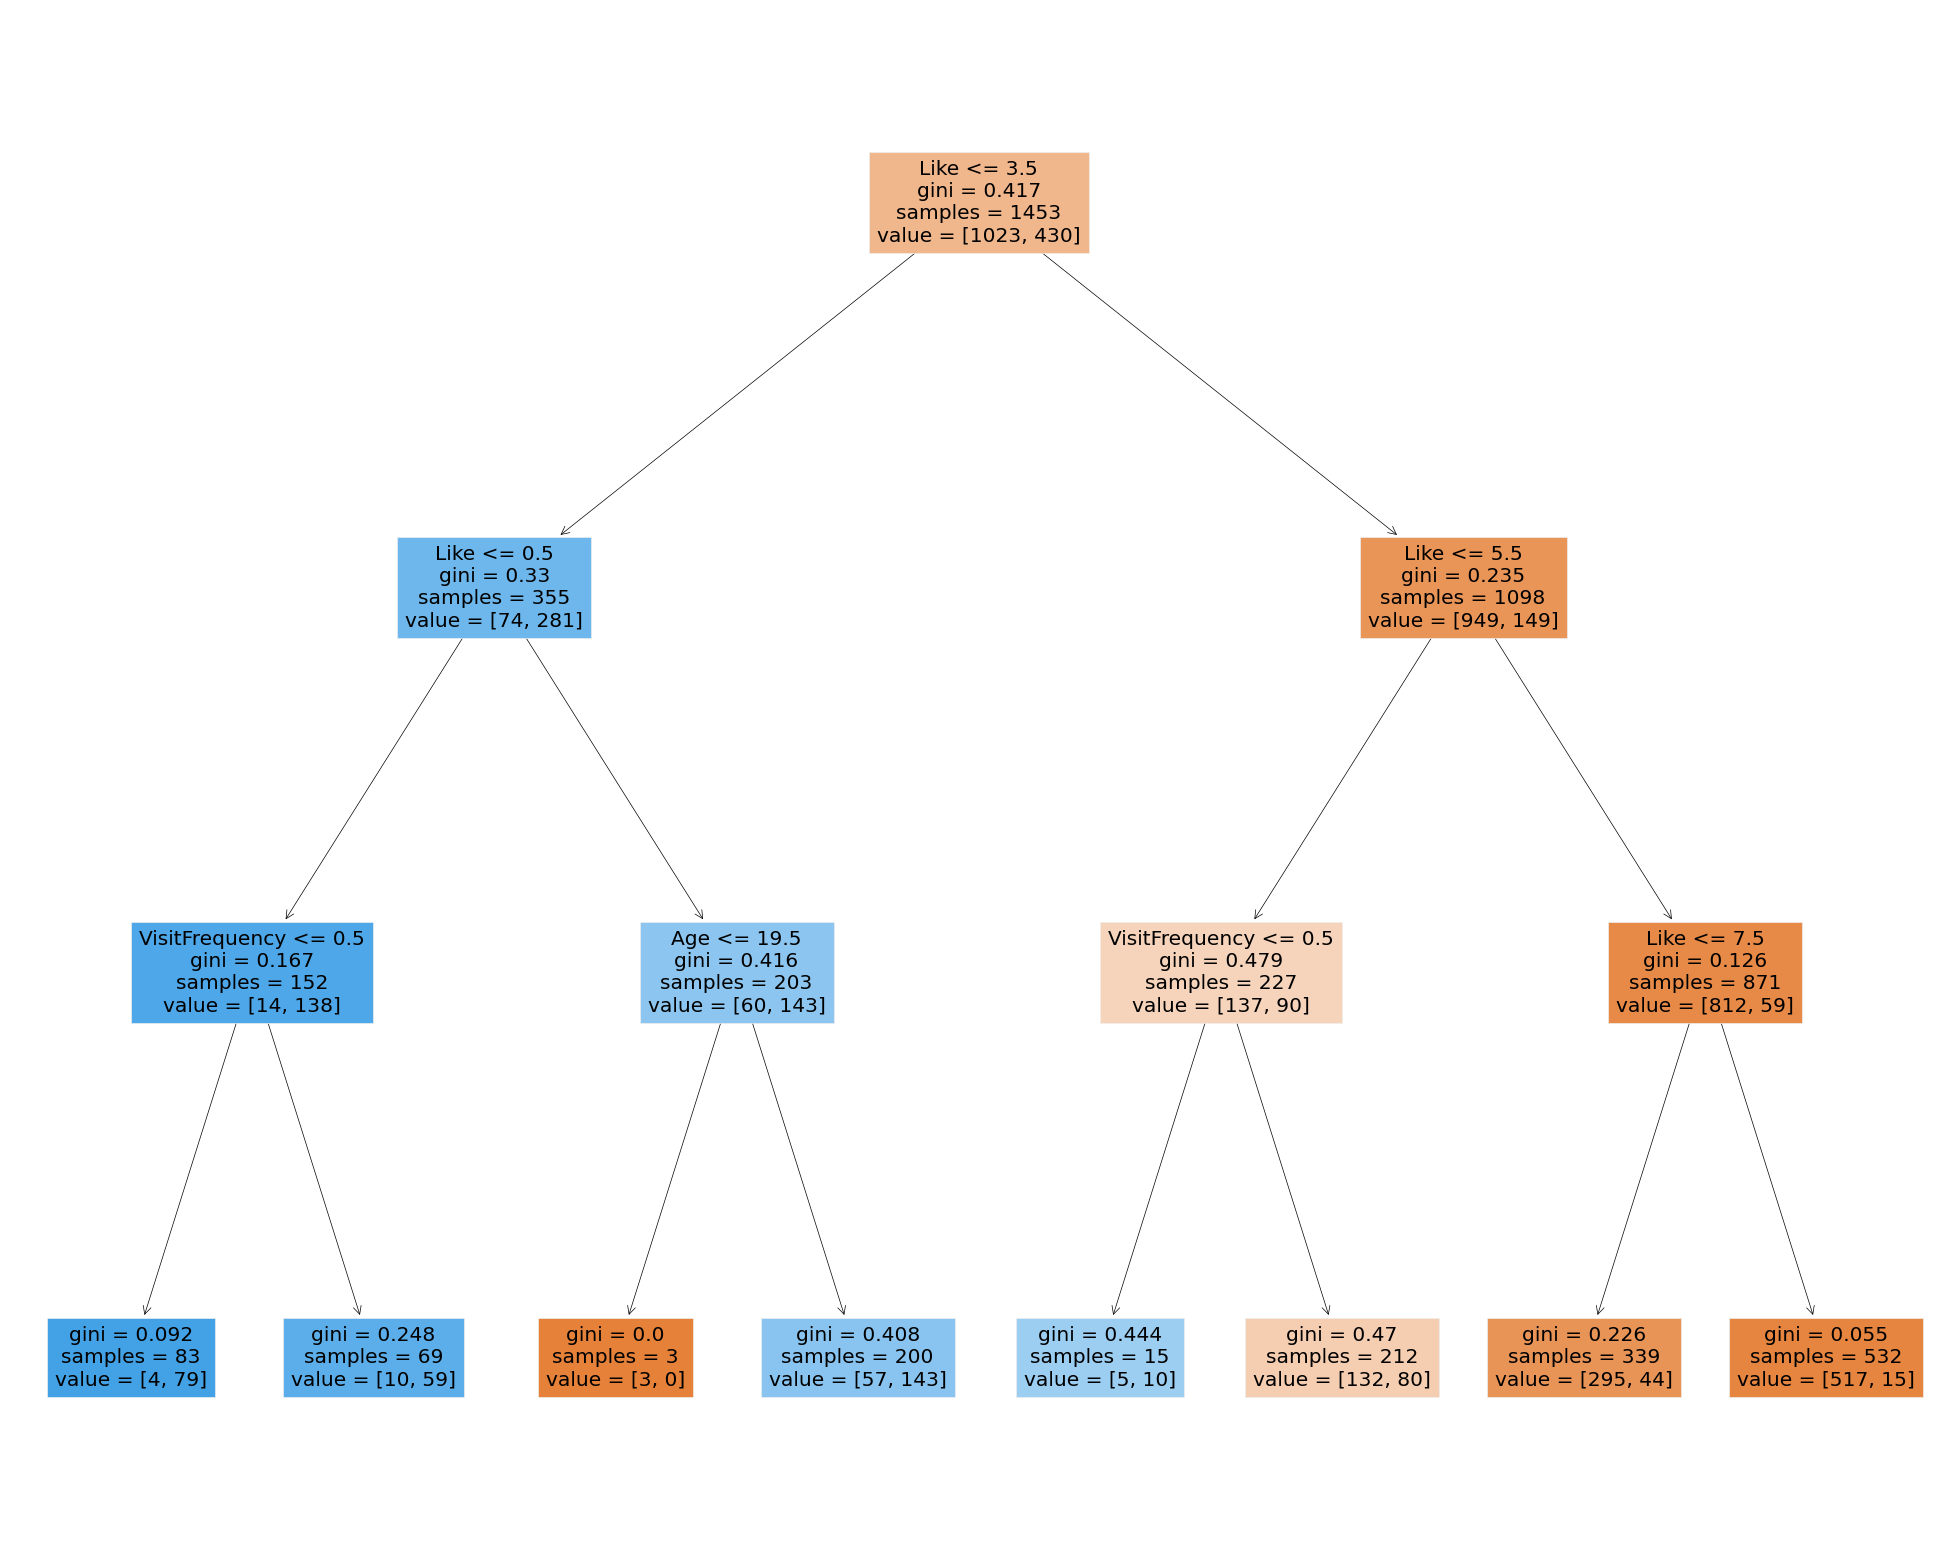

In [24]:
#visualizing the tree

fig = plt.figure(figsize=(25,20))
tr = tree.plot_tree(dtc, filled=True,feature_names=X.columns)